In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import random
import cv2

In [ ]:
train_path = "data/train"
test_path = "data/test"

# Visualização de Exemplos das Classes de Emoção

Este código tem como objetivo visualizar exemplos aleatórios de imagens de cada classe de emoção presentes no conjunto de treinamento do FER2013.

1. `classes = os.listdir(train_path)`: Lista todas as subpastas dentro do diretório de treino, onde cada subpasta representa uma classe de emoção.

2. `plt.figure(figsize=(10, 5))`: Cria uma nova figura do Matplotlib com tamanho 10x5 polegadas para exibir as imagens.

3. O loop `for i, emotion in enumerate(classes)`:
   - Obtém o caminho para a pasta da emoção atual
   - Seleciona aleatoriamente uma imagem da pasta
   - Lê a imagem usando OpenCV
   - Converte a imagem de BGR (padrão do OpenCV) para RGB (padrão do Matplotlib)
   - Cria um subplot para a imagem
   - Exibe a imagem com o título da emoção

4. Por fim, ajusta o layout e exibe a figura com `plt.tight_layout()` e `plt.show()`

In [ ]:
classes = os.listdir(train_path)
print(f"Classes encontradas: {classes}")
print(f"Número de classes (diretórios): {len(classes)}")

plt.figure(figsize=(10, 5))
for i, emotion in enumerate(classes):
    emotion_path = os.path.join(train_path, emotion)
    random_img = random.choice(os.listdir(emotion_path))
    img_path = os.path.join(emotion_path, random_img)
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(1, len(classes), i+1)
    plt.imshow(img)
    plt.title(emotion)
    plt.axis("off")

plt.tight_layout()
plt.show()

# Configurações do Modelo e Parâmetros de Treinamento

Aqui definimos os parâmetros fundamentais para o treinamento do nosso modelo de reconhecimento de emoções:

- `IMG_SIZE = (48, 48)`: Define o tamanho padrão das imagens de entrada. As imagens do FER2013 são padronizadas em 48x48 pixels em escala de cinza, o que é ideal para processamento eficiente mantendo os detalhes faciais essenciais.

- `BATCH_SIZE = 128`: Especifica o número de amostras processadas antes da atualização dos pesos do modelo. Um batch size de 128 oferece um bom equilíbrio entre velocidade de treinamento e uso de memória.

- `EPOCHS = 100`: Define o número máximo de vezes que o modelo irá processar todo o conjunto de dados durante o treinamento. Com 100 épocas, damos tempo suficiente para o modelo aprender os padrões, enquanto os callbacks (como EarlyStopping) podem interromper o treinamento se não houver mais melhorias.

- `NUM_CLASSES = 7`: Indica o número de emoções diferentes que nosso modelo irá classificar (angry, disgust, fear, happy, neutral, sad, surprise).

In [ ]:
IMG_SIZE = (48, 48)
BATCH_SIZE = 128
EPOCHS = 10
NUM_CLASSES = 7

# Criação e Configuração dos Datasets

Este código é responsável pela criação e configuração dos datasets de treinamento, validação e teste para o modelo de reconhecimento de emoções.

1. **Função `create_dataset`**:
   - Utiliza `tf.keras.utils.image_dataset_from_directory` para carregar imagens
   - Parâmetros importantes:
     - `validation_split`: Define a proporção de dados para validação (20%)
     - `seed`: Garante reprodutibilidade
     - `image_size`: Padroniza as imagens para 48x48
     - `color_mode='grayscale'`: Carrega em escala de cinza
     - `shuffle`: Embaralha os dados

2. **Camada de Data Augmentation**:
   - Realiza transformações nos dados de treino para aumentar a variabilidade:
     - Rescaling: Normaliza os valores dos pixels para [0,1]
     - Rotação aleatória (±20 graus)
     - Translação aleatória (±10%)
     - Zoom aleatório (±10%)
     - Flip horizontal

3. **Carregamento dos Datasets**:
   - `train_ds_raw`: 80% dos dados de treino
   - `val_ds_raw`: 20% dos dados de treino para validação
   - `test_ds_raw`: Dados de teste separados

4. **Otimizações de Performance**:
   - `cache()`: Mantém os dados em memória
   - `shuffle()`: Embaralha os dados (apenas treino)
   - `prefetch()`: Otimiza o carregamento dos batches

In [18]:
def create_dataset(directory, validation_split=None, subset=None):
    return tf.keras.utils.image_dataset_from_directory(
        directory,
        validation_split=validation_split,
        subset=subset,
        seed=123,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        color_mode='grayscale',
        shuffle=True
    )

# Define a camada de pré-processamento de dados
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomRotation(20 / 360),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomFlip("horizontal")
])

# Carregua os conjuntos de dados de treinamento e validação
train_ds_raw = create_dataset(
    train_path,
    validation_split=0.2, # 20% dos dados para validação
    subset="training"
)

val_ds_raw = create_dataset(
    train_path,
    validation_split=0.2, # 20% dos dados para validação
    subset="validation"
)

test_ds_raw = create_dataset(test_path)

# Captura nomes de classes antes de aplicar otimizações de desempenho
class_names = train_ds_raw.class_names
#print("Classes:", class_names)

# Configura conjuntos de dados para desempenho
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds_raw.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds_raw.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds_raw.cache().prefetch(buffer_size=AUTOTUNE)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


# Visualização dos Dados e Aumento de dados

Esta seção implementa e utiliza uma função para visualizar as imagens do dataset, tanto em seu formato original quanto após a aplicação das transformações de data augmentation, permitindo uma comparação direta entre as versões.

1. **Função `visualize_dataset`**:
   - Recebe como parâmetros:
     - `dataset`: O conjunto de dados a ser visualizado
     - `augmentation_layer`: Camada opcional de augmentação
     - `num_images`: Número de imagens a serem exibidas
   
   - Funcionalidade:
     - Cria uma figura mais larga (15x5) para melhor visualização
     - Extrai e armazena em memória um batch de imagens e seus rótulos
     - Organiza a visualização em duas linhas:
       - Linha superior: imagens originais
       - Linha inferior: imagens após augmentação
     - Para cada imagem:
       - Converte para formato numpy e tipo uint8
       - Exibe a versão original
       - Se houver augmentation_layer:
         - Aplica as transformações
         - Exibe a versão transformada abaixo da original
         - Adiciona "(Augmented)" ao título

2. **Visualização Comparativa**:
   - Mostra as mesmas imagens antes e depois do data augmentation
   - Facilita a comparação direta das transformações aplicadas
   - Mantém o contexto visual entre original e aumentada

Esta visualização é crucial para:
- Verificar se os dados estão sendo carregados corretamente
- Validar o efeito das transformações de data augmentation
- Garantir que as transformações mantêm as características essenciais das expressões
- Comparar diretamente o impacto das transformações em cada imagem

Comparação entre Imagens Originais e Aumentadas:


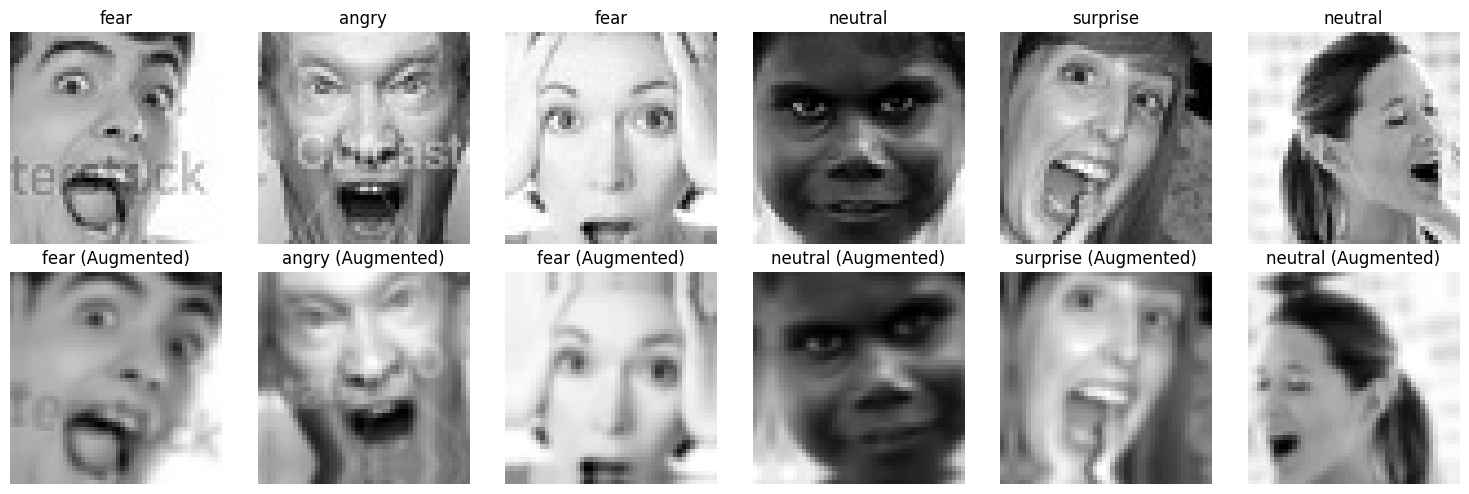

In [25]:
# Função de visualização para o conjunto de dados
def visualize_dataset(dataset, augmentation_layer=None, num_images=6):
    plt.figure(figsize=(15, 5))

    # Obtém um lote de imagens e mantém em memória
    images_batch = None
    labels_batch = None
    for images, labels in dataset.take(1):
        images_batch = images
        labels_batch = labels
        break
    
    for i in range(min(num_images, len(images_batch))):
        ax = plt.subplot(2, num_images, i + 1)
        img = images_batch[i].numpy().astype("uint8")
        plt.imshow(img, cmap='gray')
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")
        
        if augmentation_layer is not None:
            ax = plt.subplot(2, num_images, i + 1 + num_images)
            # Adiciona dimensão de lote e aplica aumento
            augmented_img = augmentation_layer(tf.expand_dims(img, 0))[0]
            plt.imshow(augmented_img, cmap='gray')
            plt.title(f"{class_names[labels_batch[i]]} (Augmented)")
            plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Visualiza imagens originais e aumentadas
print("Comparação entre Imagens Originais e Aumentadas:")
visualize_dataset(train_ds, data_augmentation)